Using device: cuda
Output directory for preprocessed scans: C:\Users\rouaa\Documents\Final_Pneumatect\PreProCessing
Model output directory: C:\Users\rouaa\Documents\Final_Pneumatect\Models
Loaded 1595 patient labels.
Label distribution:
 cancer
0    1176
1     419
Name: count, dtype: int64
Available Cancer scans: 27
Available Non-Cancer scans: 71
Selected 54 scans for preprocessing.

Starting preprocessing for 54 scans


Preprocessing Scans: 100%|██████████| 54/54 [01:09<00:00,  1.28s/it]



Preprocessing completed in 69.34 seconds.
Successfully processed: 54 scans.
Training patients: 43
Validation patients: 11


C:\Users\rouaa\AppData\Local\Temp\ipykernel_16240\3096823641.py:615: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())



Epoch 1/10


Train Loss: 0.6798, Train Acc: 0.4651
Val Loss: 0.6835, Val Acc: 0.4545
Saved best model to C:\Users\rouaa\Documents\Final_Pneumatect\Models\unetpp_se_transformer_best.pth

Epoch 2/10


Train Loss: 0.6792, Train Acc: 0.4186
Val Loss: 0.6825, Val Acc: 0.4545
Saved best model to C:\Users\rouaa\Documents\Final_Pneumatect\Models\unetpp_se_transformer_best.pth

Epoch 3/10


Train Loss: 0.6807, Train Acc: 0.4884
Val Loss: 0.6691, Val Acc: 0.5455
Saved best model to C:\Users\rouaa\Documents\Final_Pneumatect\Models\unetpp_se_transformer_best.pth

Epoch 4/10


Train Loss: 0.6827, Train Acc: 0.4884
Val Loss: 0.6823, Val Acc: 0.4545

Epoch 5/10


Train Loss: 0.6807, Train Acc: 0.4884
Val Loss: 0.6794, Val Acc: 0.4545

Epoch 6/10


Train Loss: 0.6804, Train Acc: 0.4186
Val Loss: 0.6790, Val Acc: 0.2727

Epoch 7/10


Train Loss: 0.6805, Train Acc: 0.4651
Val Loss: 0.6802, Val Acc: 0.4545

Epoch 8/10


Train Loss: 0.6760, Train Acc: 0.5814
Val Loss: 0.6788, Val Acc: 0.5455

Epoch 9/10


Train Loss: 0.6700, Train Acc: 0.6047
Val Loss: 0.6804, Val Acc: 0.4545

Epoch 10/10


Train Loss: 0.6815, Train Acc: 0.5581
Val Loss: 0.6790, Val Acc: 0.4545
Training curves saved to C:\Users\rouaa\Documents\Final_Pneumatect\Models\training_curves.png


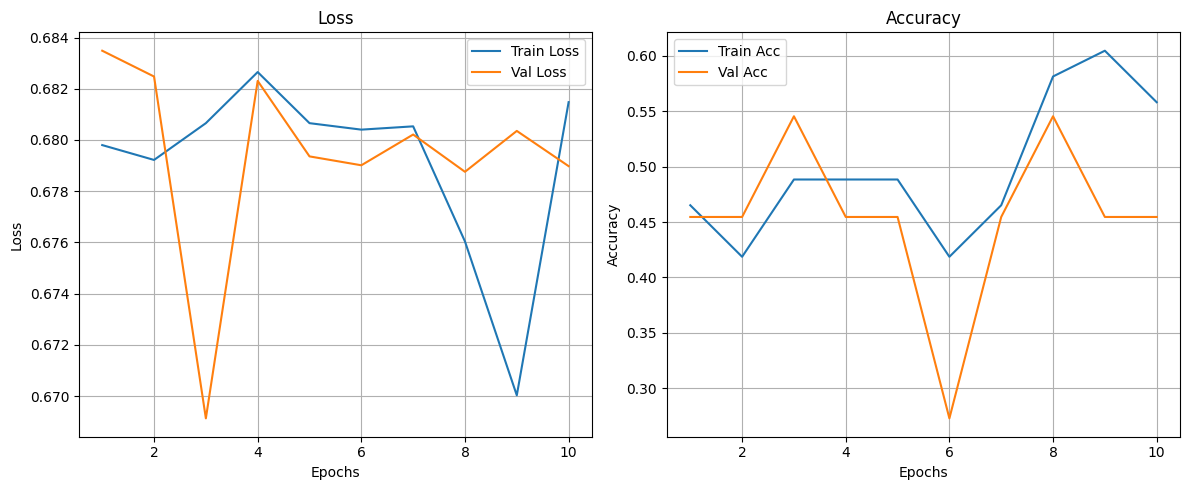

C:\Users\rouaa\AppData\Local\Temp\ipykernel_16240\3096823641.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_loca


Final Validation Loss: 0.6691
Accuracy: 0.5455
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.5333333333333333

Classification Report:
              precision    recall  f1-score   support

  Non-Cancer       0.55      1.00      0.71         6
      Cancer       0.00      0.00      0.00         5

    accuracy                           0.55        11
   macro avg       0.27      0.50      0.35        11
weighted avg       0.30      0.55      0.39        11

Confusion matrix saved to C:\Users\rouaa\Documents\Final_Pneumatect\Models\confusion_matrix.png


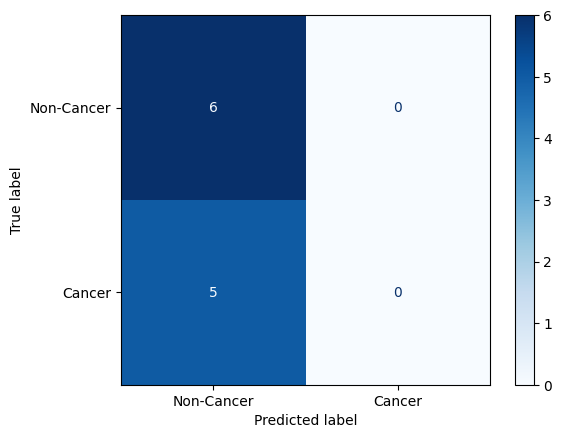

ROC curve saved to C:\Users\rouaa\Documents\Final_Pneumatect\Models\roc_curve.png


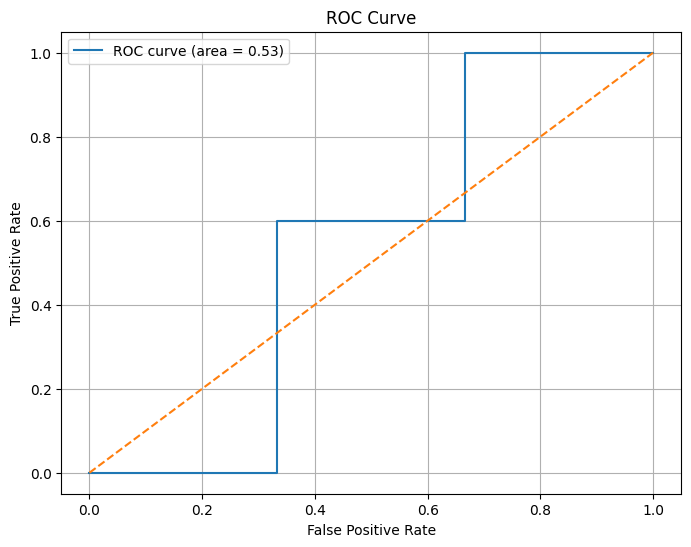

In [1]:
# %% Imports
import os
import glob
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import SimpleITK as sitk
from scipy import ndimage
from skimage.measure import label as skimage_label, regionprops
from skimage.morphology import disk, binary_closing
from skimage.segmentation import clear_border
from tqdm import tqdm

# %% Configuration
class Config:
    """Configuration class for all hyperparameters and paths."""
    # Paths
    DSB_PATH = r"C:\Users\rouaa\Documents\Final_Pneumatect\Stages"
    DSB_LABELS_CSV = r"C:\Users\rouaa\Documents\Final_Pneumatect\stage1_labels.csv"
    PREPROCESSED_DSB_PATH = r"C:\Users\rouaa\Documents\Final_Pneumatect\PreProCessing"
    MODEL_OUTPUT_DIR = r"C:\Users\rouaa\Documents\Final_Pneumatect\Models"
    
    # Preprocessing Parameters
    TARGET_SPACING = [1.5, 1.5, 1.5]  # mm (z, y, x)
    FINAL_SCAN_SIZE = (64, 64, 64)    # (d, h, w)
    CLIP_BOUND_HU = [-1000.0, 400.0]  # Hounsfield Unit bounds
    PIXEL_MEAN = 0.25                 # For zero-centering
    
    # Data Selection
    SCAN_LIMIT_PER_CLASS = 50
    SEED = 42
    FORCE_REPROCESS = False
    
    # Training Parameters
    BATCH_SIZE = 4
    NUM_CLASSES = 1
    LEARNING_RATE = 1e-3
    EPOCHS = 10
    NUM_WORKERS = 0  # Set to 0 for debugging, increase for performance
    
    # Model Hyperparameters
    UNETPP_INITIAL_FILTERS = 16
    UNETPP_DEPTH = 3
    UNETPP_TRANSFORMER_EMBED_DIM = UNETPP_INITIAL_FILTERS * (2 ** UNETPP_DEPTH)
    UNETPP_TRANSFORMER_LAYERS = 1
    UNETPP_TRANSFORMER_HEADS = 4
    UNETPP_FINAL_FC_UNITS = 64

# Set random seeds for reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(Config.SEED)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Ensure output directories exist
os.makedirs(Config.PREPROCESSED_DSB_PATH, exist_ok=True)
os.makedirs(Config.MODEL_OUTPUT_DIR, exist_ok=True)
print(f"Output directory for preprocessed scans: {Config.PREPROCESSED_DSB_PATH}")
print(f"Model output directory: {Config.MODEL_OUTPUT_DIR}")

# %% Preprocessing Functions
def load_scan_series(dicom_folder_path):
    """Load a DICOM series into a NumPy array."""
    try:
        series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(dicom_folder_path)
        if not series_ids:
            print(f"No series found in {dicom_folder_path}")
            return None, None, None
        series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(dicom_folder_path, series_ids[0])
        series_reader = sitk.ImageSeriesReader()
        series_reader.SetFileNames(series_file_names)
        itkimage = series_reader.Execute()
        image_array = sitk.GetArrayFromImage(itkimage)
        origin = np.array(list(reversed(itkimage.GetOrigin())))
        spacing = np.array(list(reversed(itkimage.GetSpacing())))
        return image_array, origin, spacing
    except Exception as e:
        print(f"Error reading DICOM series in {os.path.basename(dicom_folder_path)}: {e}")
        return None, None, None

def resample(image, original_spacing, new_spacing=Config.TARGET_SPACING):
    """Resample a 3D image to a new spacing."""
    try:
        resize_factor = np.array(original_spacing) / np.array(new_spacing)
        new_shape = np.round(image.shape * resize_factor).astype(int)
        real_resize_factor = new_shape / image.shape
        actual_new_spacing = original_spacing / real_resize_factor
        resampled_image = ndimage.zoom(image, real_resize_factor, mode='nearest', order=1)
        return resampled_image, actual_new_spacing
    except Exception as e:
        print(f"Error during resampling: {e}")
        return None, None

def get_segmented_lungs(im_slice, hu_threshold=-320):
    """Segment lungs from a 2D slice."""
    if im_slice.ndim != 2:
        return im_slice
    binary = im_slice < hu_threshold
    cleared = clear_border(binary)
    label_image = skimage_label(cleared)
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    area_threshold = 0
    if len(areas) >= 2:
        area_threshold = areas[-2]
    elif len(areas) == 1:
        area_threshold = areas[-1]
    if area_threshold > 0:
        for region in regionprops(label_image):
            if region.area < area_threshold:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    selem_close = disk(2)
    binary = binary_closing(binary, selem_close)
    selem_dilate = disk(5)
    final_mask = ndimage.binary_dilation(binary, structure=selem_dilate)
    segmented_slice = im_slice.copy()
    segmented_slice[final_mask == 0] = Config.CLIP_BOUND_HU[0] - 1.0
    return segmented_slice

def normalize_hu(image, clip_bounds=Config.CLIP_BOUND_HU):
    """Normalize HU values to [0, 1]."""
    min_bound, max_bound = clip_bounds
    image = np.clip(image, min_bound, max_bound)
    image = (image - min_bound) / (max_bound - min_bound)
    return image.astype(np.float32)

def zero_center(image, pixel_mean=Config.PIXEL_MEAN):
    """Zero-center the normalized image."""
    return (image - pixel_mean).astype(np.float32)

def resize_scan_to_target(image, target_shape=Config.FINAL_SCAN_SIZE):
    """Resize a 3D array to the target shape."""
    if image.shape == target_shape:
        return image.astype(np.float32)
    resize_factor = np.array(target_shape) / np.array(image.shape)
    try:
        resized_image = ndimage.zoom(image, resize_factor, order=1, mode='nearest')
        if resized_image.shape != target_shape:
            current_shape = np.array(resized_image.shape)
            target_shape_arr = np.array(target_shape)
            diff = target_shape_arr - current_shape
            pad_amount = np.maximum(diff, 0)
            crop_amount = np.maximum(-diff, 0)
            pad_width = tuple((p // 2, p - p // 2) for p in pad_amount)
            resized_image = np.pad(resized_image, pad_width, mode='edge')
            crop_slice = tuple(slice(c // 2, s - (c - c // 2)) for c, s in zip(crop_amount, resized_image.shape))
            resized_image = resized_image[crop_slice]
        if resized_image.shape != target_shape:
            print(f"Resize failed. Target: {target_shape}, Got: {resized_image.shape}")
            return None
        return resized_image.astype(np.float32)
    except Exception as e:
        print(f"Error resizing image: {e}")
        return None

def preprocess_scan_dsb(patient_id, input_base_path, output_base_path, force_preprocess=False):
    """Apply full preprocessing pipeline and save the result."""
    scan_folder_path = os.path.join(input_base_path, patient_id)
    output_filename = os.path.join(output_base_path, f"{patient_id}.npz")
    if os.path.exists(output_filename) and not force_preprocess:
        return True

    image, origin, spacing = load_scan_series(scan_folder_path)
    if image is None:
        return False
    resampled_image, new_spacing = resample(image, spacing)
    if resampled_image is None:
        del image
        return False
    del image
    segmented_lungs = np.zeros_like(resampled_image, dtype=np.float32)
    for i in range(resampled_image.shape[0]):
        segmented_lungs[i] = get_segmented_lungs(resampled_image[i])
    del resampled_image
    normalized_image = normalize_hu(segmented_lungs)
    del segmented_lungs
    centered_image = zero_center(normalized_image)
    del normalized_image
    final_image = resize_scan_to_target(centered_image)
    del centered_image
    if final_image is None:
        return False
    try:
        np.savez_compressed(output_filename, image=final_image)
        return True
    except Exception as e:
        print(f"Error saving scan for {patient_id}: {e}")
        if os.path.exists(output_filename):
            try:
                os.remove(output_filename)
            except OSError:
                pass
        return False

# %% Data Loading and Selection
def load_and_select_data():
    """Load labels and select a balanced dataset."""
    # Verify paths
    if not os.path.isdir(Config.DSB_PATH):
        raise SystemExit(f"DSB Scans path not found: {Config.DSB_PATH}")
    if not os.path.isfile(Config.DSB_LABELS_CSV):
        raise SystemExit(f"Labels CSV not found: {Config.DSB_LABELS_CSV}")

    # Load labels
    try:
        dsb_labels_df = pd.read_csv(Config.DSB_LABELS_CSV)
        dsb_labels_df = dsb_labels_df.rename(columns={'id': 'patient_id'})
        print(f"Loaded {len(dsb_labels_df)} patient labels.")
        if 'cancer' not in dsb_labels_df.columns:
            raise ValueError("Labels CSV needs a 'cancer' column.")
        print("Label distribution:\n", dsb_labels_df['cancer'].value_counts())
        patient_labels_all = dsb_labels_df.set_index('patient_id')['cancer'].to_dict()
    except Exception as e:
        raise SystemExit(f"Failed to load labels CSV: {e}")

    # Check scan folders
    scan_folders = [f for f in os.listdir(Config.DSB_PATH) if os.path.isdir(os.path.join(Config.DSB_PATH, f))]
    if not scan_folders:
        raise SystemExit(f"No subdirectories found in DSB_PATH: {Config.DSB_PATH}")
    found_scan_ids = set(scan_folders)

    # Find common IDs
    labeled_patient_ids_all = set(patient_labels_all.keys())
    common_ids_all = labeled_patient_ids_all.intersection(found_scan_ids)
    if not common_ids_all:
        raise SystemExit("No matching patient IDs found.")

    # Separate by class
    common_ids_cancer = [pid for pid in common_ids_all if patient_labels_all.get(pid) == 1]
    common_ids_non_cancer = [pid for pid in common_ids_all if patient_labels_all.get(pid) == 0]
    print(f"Available Cancer scans: {len(common_ids_cancer)}")
    print(f"Available Non-Cancer scans: {len(common_ids_non_cancer)}")

    if not common_ids_cancer or not common_ids_non_cancer:
        raise SystemExit("Cannot create balanced dataset: One class has zero scans.")

    # Select balanced subset
    num_to_select = min(len(common_ids_cancer), len(common_ids_non_cancer), Config.SCAN_LIMIT_PER_CLASS)
    if num_to_select == 0:
        raise SystemExit("Cannot select any scans based on limits.")
    
    random.shuffle(common_ids_cancer)
    random.shuffle(common_ids_non_cancer)
    selected_cancer_ids = common_ids_cancer[:num_to_select]
    selected_non_cancer_ids = common_ids_non_cancer[:num_to_select]
    scans_to_process = selected_cancer_ids + selected_non_cancer_ids
    random.shuffle(scans_to_process)
    
    patient_labels_selected = {pid: patient_labels_all[pid] for pid in scans_to_process}
    print(f"Selected {len(scans_to_process)} scans for preprocessing.")
    
    return scans_to_process, patient_labels_selected

# %% Preprocessing Execution
def preprocess_scans(scans_to_process):
    """Preprocess selected scans."""
    successful_ids = []
    failed_ids = []
    
    print(f"\nStarting preprocessing for {len(scans_to_process)} scans")
    start_time = time.time()
    
    for patient_id in tqdm(scans_to_process, desc="Preprocessing Scans"):
        success = preprocess_scan_dsb(
            patient_id=patient_id,
            input_base_path=Config.DSB_PATH,
            output_base_path=Config.PREPROCESSED_DSB_PATH,
            force_preprocess=Config.FORCE_REPROCESS
        )
        if success:
            successful_ids.append(patient_id)
        else:
            failed_ids.append(patient_id)
            print(f"Failed processing patient: {patient_id}")
    
    end_time = time.time()
    print(f"\nPreprocessing completed in {end_time - start_time:.2f} seconds.")
    print(f"Successfully processed: {len(successful_ids)} scans.")
    if failed_ids:
        print(f"Failed to process: {len(failed_ids)} scans.")
    
    return successful_ids

# %% Dataset and DataLoader
class PatientLevelDataset(Dataset):
    """Dataset for loading preprocessed patient scans."""
    def __init__(self, patient_ids, labels_dict, preprocessed_path):
        self.patient_ids = patient_ids
        self.labels_dict = labels_dict
        self.preprocessed_path = preprocessed_path
        self.target_size = Config.FINAL_SCAN_SIZE

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        label = self.labels_dict.get(patient_id, -1)
        scan_path = os.path.join(self.preprocessed_path, f"{patient_id}.npz")
        try:
            with np.load(scan_path) as npz_data:
                image = npz_data['image']
            if image.shape != self.target_size:
                print(f"Shape mismatch for {patient_id}: Expected {self.target_size}, got {image.shape}")
                return torch.zeros((1, *self.target_size), dtype=torch.float32), torch.tensor(-1, dtype=torch.float32)
            image_tensor = torch.from_numpy(image).float().unsqueeze(0)
            label_tensor = torch.tensor(label, dtype=torch.float32)
            return image_tensor, label_tensor
        except Exception as e:
            print(f"Error loading {patient_id}: {e}")
            return torch.zeros((1, *self.target_size), dtype=torch.float32), torch.tensor(-1, dtype=torch.float32)

def create_dataloaders(successful_ids, patient_labels):
    """Create train and validation DataLoaders."""
    train_ids, val_ids = train_test_split(
        successful_ids,
        test_size=0.2,
        random_state=Config.SEED,
        stratify=[patient_labels[pid] for pid in successful_ids]
    )
    print(f"Training patients: {len(train_ids)}")
    print(f"Validation patients: {len(val_ids)}")

    train_dataset = PatientLevelDataset(train_ids, patient_labels, Config.PREPROCESSED_DSB_PATH)
    val_dataset = PatientLevelDataset(val_ids, patient_labels, Config.PREPROCESSED_DSB_PATH)

    train_loader = DataLoader(
        train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True,
        num_workers=Config.NUM_WORKERS, pin_memory=torch.cuda.is_available()
    )
    val_loader = DataLoader(
        val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False,
        num_workers=Config.NUM_WORKERS, pin_memory=torch.cuda.is_available()
    )
    
    return train_loader, val_loader, train_ids, val_ids

# %% Model Definition
class SEBlock3D(nn.Module):
    """3D Squeeze-and-Excitation Block."""
    def __init__(self, channels, reduction=16):
        super(SEBlock3D, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool3d(1)
        self.excitation = nn.Sequential(
            nn.Conv3d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.squeeze(x)
        y = self.excitation(y)
        return x * y

class ConvBlock3D(nn.Module):
    """Double Conv -> BN -> ReLU with optional SE."""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, use_se=True):
        super(ConvBlock3D, self).__init__()
        self.use_se = use_se
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.se = SEBlock3D(out_channels) if use_se else nn.Identity()

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.se(x)
        return x

class TransformerEncoderLayer3D(nn.Module):
    """3D Transformer Encoder Layer."""
    def __init__(self, embed_dim, num_heads, ff_dim_factor=4, dropout=0.1):
        super(TransformerEncoderLayer3D, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * ff_dim_factor),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * ff_dim_factor, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        attn_output, _ = self.attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        ffn_output = self.ffn(src)
        src = src + self.dropout2(ffn_output)
        src = self.norm2(src)
        return src

class TransformerBottleneck(nn.Module):
    """Transformer Bottleneck for U-Net++."""
    def __init__(self, in_channels, embed_dim, num_layers, num_heads, bottleneck_spatial_dims, dropout=0.1):
        super(TransformerBottleneck, self).__init__()
        self.patch_projection = nn.Conv3d(in_channels, embed_dim, kernel_size=1) if in_channels != embed_dim else nn.Identity()
        self.pos_embed = nn.Parameter(torch.randn(1, np.prod(bottleneck_spatial_dims), embed_dim))
        self.dropout_pos = nn.Dropout(dropout)
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer3D(embed_dim, num_heads, dropout=dropout) for _ in range(num_layers)
        ])
        self.norm_out = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.patch_projection(x)
        b, e, d, h, w = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        x = self.dropout_pos(x)
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.norm_out(x)
        x = x.transpose(1, 2).view(b, e, d, h, w)
        return x

class UNetPlusPlus_SE_Transformer(nn.Module):
    """U-Net++ with SE and Transformer."""
    def __init__(self, input_scan_size, in_channels=1, num_classes=1, initial_filters=16, depth=4,
                 use_se=True, transformer_embed_dim=256, transformer_layers=2, transformer_heads=8,
                 transformer_dropout=0.1, final_fc_units=128):
        super(UNetPlusPlus_SE_Transformer, self).__init__()
        self.depth = depth
        nf = initial_filters
        s_d, s_h, s_w = (input_scan_size[i] // (2**depth) for i in range(3))

        # Encoder
        self.pools = nn.ModuleList()
        self.encoder_blocks = nn.ModuleList()
        encoder_output_channels = []
        current_channels_enc = in_channels
        for i in range(depth + 1):
            out_ch_enc = nf * (2**i)
            self.encoder_blocks.append(ConvBlock3D(current_channels_enc, out_ch_enc, use_se=use_se))
            encoder_output_channels.append(out_ch_enc)
            if i < depth:
                self.pools.append(nn.MaxPool3d(2, 2))
            current_channels_enc = out_ch_enc

        # Transformer Bottleneck
        self.transformer_bottleneck = TransformerBottleneck(
            in_channels=encoder_output_channels[-1],
            embed_dim=transformer_embed_dim,
            num_layers=transformer_layers,
            num_heads=transformer_heads,
            bottleneck_spatial_dims=(s_d, s_h, s_w),
            dropout=transformer_dropout
        )

        # Decoder
        self.decoder_conv_modulelist = nn.ModuleList()
        self.upsamplers = nn.ModuleList()
        for i in range(depth):
            ch_from_below = transformer_embed_dim if (i + 1) == depth else encoder_output_channels[i+1]
            ch_to_current = encoder_output_channels[i]
            self.upsamplers.append(nn.ConvTranspose3d(ch_from_below, ch_to_current, kernel_size=2, stride=2))

        for i in range(depth):
            level_i_decoder_blocks = nn.ModuleList()
            for j in range(1, depth - i + 1):
                in_ch_Xij = encoder_output_channels[i] * (j + 1)
                out_ch_Xij = encoder_output_channels[i]
                level_i_decoder_blocks.append(ConvBlock3D(in_ch_Xij, out_ch_Xij, use_se=use_se))
            self.decoder_conv_modulelist.append(level_i_decoder_blocks)

        # Classification Head
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(encoder_output_channels[0], final_fc_units),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(final_fc_units, num_classes)
        )

    def forward(self, x):
        X_features = [[None] * (self.depth + 1) for _ in range(self.depth + 1)]
        current = x
        for i in range(self.depth + 1):
            X_features[i][0] = self.encoder_blocks[i](current)
            if i < self.depth:
                current = self.pools[i](X_features[i][0])
            else:
                current = X_features[i][0]
        X_features[self.depth][0] = self.transformer_bottleneck(X_features[self.depth][0])
        for i in range(self.depth - 1, -1, -1):
            for j in range(1, self.depth - i + 1):
                inputs_same_level = [X_features[i][k] for k in range(j)]
                upsampled_input = self.upsamplers[i](X_features[i+1][j-1])
                target_spatial = X_features[i][0].shape[2:]
                if upsampled_input.shape[2:] != target_spatial:
                    upsampled_input = torch.nn.functional.interpolate(
                        upsampled_input, size=target_spatial, mode='trilinear', align_corners=False
                    )
                combined = torch.cat(inputs_same_level + [upsampled_input], dim=1)
                X_features[i][j] = self.decoder_conv_modulelist[i][j-1](combined)
        logits = self.classification_head(X_features[0][self.depth])
        return logits

# %% Training and Validation Functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        valid_indices = labels != -1
        if not torch.any(valid_indices):
            continue
        inputs = inputs[valid_indices].to(device)
        labels = labels[valid_indices].unsqueeze(1).to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        if torch.isnan(loss):
            print("NaN loss encountered, skipping batch.")
            continue
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        correct_predictions += (preds == labels.bool()).sum().item()
    if total_samples == 0:
        return 0.0, 0.0
    return running_loss / total_samples, correct_predictions / total_samples

def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    total_samples = 0
    all_preds_proba = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating", leave=False):
            valid_indices = labels != -1
            if not torch.any(valid_indices):
                continue
            inputs = inputs[valid_indices].to(device)
            labels = labels[valid_indices].to(device)
            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
            if torch.isnan(loss):
                continue
            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
            all_preds_proba.extend(torch.sigmoid(outputs).cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    if total_samples == 0:
        return 0.0, np.array([]), np.array([])
    return running_loss / total_samples, np.array(all_labels), np.array(all_preds_proba)

# %% Main Execution
def main():
    """Main execution function."""
    # Load and select data
    scans_to_process, patient_labels = load_and_select_data()
    
    # Preprocess scans
    successful_ids = preprocess_scans(scans_to_process)
    
    # Create DataLoaders
    train_loader, val_loader, train_ids, val_ids = create_dataloaders(successful_ids, patient_labels)
    
    # Initialize model
    model = UNetPlusPlus_SE_Transformer(
        input_scan_size=Config.FINAL_SCAN_SIZE,
        in_channels=1,
        num_classes=Config.NUM_CLASSES,
        initial_filters=Config.UNETPP_INITIAL_FILTERS,
        depth=Config.UNETPP_DEPTH,
        use_se=True,
        transformer_embed_dim=Config.UNETPP_TRANSFORMER_EMBED_DIM,
        transformer_layers=Config.UNETPP_TRANSFORMER_LAYERS,
        transformer_heads=Config.UNETPP_TRANSFORMER_HEADS,
        transformer_dropout=0.1,
        final_fc_units=Config.UNETPP_FINAL_FC_UNITS
    ).to(DEVICE)
    
    # Loss and optimizer
    train_labels_list = [patient_labels[pid] for pid in train_ids]
    count_0 = train_labels_list.count(0)
    count_1 = train_labels_list.count(1)
    pos_weight = torch.tensor([count_0 / count_1 if count_1 > 0 else 1.0], device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    
    # Training loop
    best_val_loss = float('inf')
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    model_save_path = os.path.join(Config.MODEL_OUTPUT_DIR, "unetpp_se_transformer_best.pth")
    
    for epoch in range(Config.EPOCHS):
        print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, scaler)
        val_loss, val_labels, val_preds_proba = validate(model, val_loader, criterion, DEVICE)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        
        val_acc = accuracy_score(val_labels, (val_preds_proba > 0.5).astype(int)) if len(val_labels) > 0 else 0.0
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss and len(val_labels) > 0:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model to {model_save_path}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, Config.EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, Config.EPOCHS + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, Config.EPOCHS + 1), train_accs, label='Train Acc')
    plt.plot(range(1, Config.EPOCHS + 1), val_accs, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plot_save_path = os.path.join(Config.MODEL_OUTPUT_DIR, "training_curves.png")
    plt.savefig(plot_save_path)
    print(f"Training curves saved to {plot_save_path}")
    plt.show()
    
    # Evaluation
    model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
    model.eval()
    val_loss, val_labels, val_preds_proba = validate(model, val_loader, criterion, DEVICE)
    
    if len(val_labels) > 0:
        val_preds_binary = (val_preds_proba > 0.5).astype(int)
        print(f"\nFinal Validation Loss: {val_loss:.4f}")
        print(f"Accuracy: {accuracy_score(val_labels, val_preds_binary):.4f}")
        print(f"Precision: {precision_score(val_labels, val_preds_binary, zero_division=0):.4f}")
        print(f"Recall: {recall_score(val_labels, val_preds_binary, zero_division=0):.4f}")
        print(f"F1-Score: {f1_score(val_labels, val_preds_binary, zero_division=0):.4f}")
        
        auc_roc = roc_auc_score(val_labels, val_preds_proba) if len(np.unique(val_labels)) > 1 else float('nan')
        print(f"AUC-ROC: {auc_roc}")
        
        print("\nClassification Report:")
        print(classification_report(val_labels.astype(int), val_preds_binary, target_names=['Non-Cancer', 'Cancer'], zero_division=0))
        
        cm = confusion_matrix(val_labels.astype(int), val_preds_binary)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancer', 'Cancer'])
        disp.plot(cmap=plt.cm.Blues)
        cm_save_path = os.path.join(Config.MODEL_OUTPUT_DIR, "confusion_matrix.png")
        plt.savefig(cm_save_path)
        print(f"Confusion matrix saved to {cm_save_path}")
        plt.show()
        
        if not np.isnan(auc_roc):
            fpr, tpr, _ = roc_curve(val_labels, val_preds_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_roc:.2f})')
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend()
            plt.grid(True)
            roc_save_path = os.path.join(Config.MODEL_OUTPUT_DIR, "roc_curve.png")
            plt.savefig(roc_save_path)
            print(f"ROC curve saved to {roc_save_path}")
            plt.show()

if __name__ == "__main__":
    main()